# **Feature Engineering Notebook**

## Objectives

*   Engineer features for Classification, Regression and Cluster models


## Inputs

* inputs/datasets/cleaned/TrainSet.csv
* inputs/datasets/cleaned/TestSet.csv

## Outputs

* generate a list with variables to engineer

## Conclusions



* Feature Engineering Transformers
  * Ordinal categorical encoding: `['xxxxxxxxxxxxxfill in from the middle result', 'xxxxxxxxxxxxx', 'xxxxxxx']`
  * Smart Correlation Selection: `['xxxxxxxxxxxxxxxxxxx fill in from the bottom result', 'xxxxxxx', 'xxxxxxxx']`
  


---

# Change working directory

We need to change the working directory from its current folder to its parent folder
* Access the current directory with os.getcwd()

In [1]:
import os
current_dir = os.getcwd()
current_dir

'/workspace/data-driven-design/jupyter_notebooks'

Make the parent of the current directory the new current directory.
* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory

In [2]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


Confirm the new current directory

In [3]:
current_dir = os.getcwd()
current_dir

'/workspace/data-driven-design'

---

# Load Feature Engineerd Data (from 4_feature_engineering_part_1)

Train Set

In [4]:
import pandas as pd
train_set_path = "outputs/datasets/feature_engineering/TrainSet.csv"
TrainSet = pd.read_csv(train_set_path)
TrainSet.head(3)

,Wing_Span,Length,Height,Multi_Engine,TP_mods,Engine_Type,AUW,MEW,FW,Vmax,...,Vstall,Range,Hmax,Hmax_(One),ROC,ROC_(One),Vlo,Slo,Vl,Sl
0,64.333333,68.416667,20.666667,0,0,2,48300.0,26985.0,20000.0,546.94,...,99.659388,4045.0,41000.0,20000.0,2512.569226,680.0,6969.145819,5684.0,3693.285251,2777.0
1,37.166667,31.166667,10.250000,0,0,0,5200.0,3229.0,964.8,220.00,...,59.000000,620.0,30000.0,18700.0,1530.000000,265.0,1250.000000,820.0,1250.000000,850.0
2,37.666667,25.583333,9.500000,0,0,0,4880.0,2960.0,750.4,200.00,...,66.000000,745.0,19200.0,7600.0,1630.000000,350.0,1700.000000,1255.0,1470.000000,1250.0


Test Set

In [5]:
test_set_path = 'outputs/datasets/feature_engineering/TestSet.csv'
TestSet = pd.read_csv(test_set_path)
TestSet.head(3)

,Wing_Span,Length,Height,Multi_Engine,TP_mods,Engine_Type,AUW,MEW,FW,Vmax,...,Vstall,Range,Hmax,Hmax_(One),ROC,ROC_(One),Vlo,Slo,Vl,Sl
0,32.750000,25.083333,6.500000,1,0,0,2650.0,1575.0,261.3,160.0,...,49.0,470.0,17100.0,17100.0,890.0,890.0,1515.0,1275.0,950.0,625.0
1,43.000000,30.083333,11.250000,1,0,1,4318.0,2900.0,1011.7,265.0,...,60.0,1000.0,27000.0,27000.0,3000.0,3000.0,1200.0,800.0,1000.0,800.0
2,44.083333,36.333333,11.416667,0,0,0,6850.0,4238.0,1427.1,230.0,...,68.0,875.0,26900.0,14800.0,1450.0,301.0,2195.0,1763.0,2485.0,1055.0


## Continuation of... "Dealing with Feature Engineering"

In [6]:
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import warnings
from feature_engine import transformation as vt
from feature_engine.outliers import Winsorizer
from feature_engine.encoding import OrdinalEncoder
sns.set(style="whitegrid")
warnings.filterwarnings('ignore')


def FeatureEngineeringAnalysis(df, analysis_type=None):
    """
    - used for quick feature engineering on numerical and categorical variables
    to decide which transformation can better transform the distribution shape
    - Once transformed, use a reporting tool, like ydata-profiling, to evaluate distributions
    """
    check_missing_values(df)
    allowed_types = ['numerical', 'ordinal_encoder', 'outlier_winsorizer']
    check_user_entry_on_analysis_type(analysis_type, allowed_types)
    list_column_transformers = define_list_column_transformers(analysis_type)

    # Loop in each variable and engineer the data according to the analysis type
    df_feat_eng = pd.DataFrame([])
    for column in df.columns:
        # create additional columns (column_method) to apply the methods
        df_feat_eng = pd.concat([df_feat_eng, df[column]], axis=1)
        for method in list_column_transformers:
            df_feat_eng[f"{column}_{method}"] = df[column]

        # Apply transformers in respective column_transformers
        df_feat_eng, list_applied_transformers = apply_transformers(
            analysis_type, df_feat_eng, column)

        # For each variable, assess how the transformations perform
        transformer_evaluation(
            column, list_applied_transformers, analysis_type, df_feat_eng)

    return df_feat_eng


def check_user_entry_on_analysis_type(analysis_type, allowed_types):
    """ Check analysis type """
    if analysis_type is None:
        raise SystemExit(
            f"You should pass analysis_type parameter as one of the following options: {allowed_types}")
    if analysis_type not in allowed_types:
        raise SystemExit(
            f"analysis_type argument should be one of these options: {allowed_types}")


def check_missing_values(df):
    if df.isna().sum().sum() != 0:
        raise SystemExit(
            f"There is a missing value in your dataset. Please handle that before getting into feature engineering.")


def define_list_column_transformers(analysis_type):
    """ Set suffix columns according to analysis_type"""
    if analysis_type == 'numerical':
        list_column_transformers = [
            "log_e", "log_10", "reciprocal", "power", "box_cox", "yeo_johnson"]

    elif analysis_type == 'ordinal_encoder':
        list_column_transformers = ["ordinal_encoder"]

    elif analysis_type == 'outlier_winsorizer':
        list_column_transformers = ['iqr']

    return list_column_transformers


def apply_transformers(analysis_type, df_feat_eng, column):
    for col in df_feat_eng.select_dtypes(include='category').columns:
        df_feat_eng[col] = df_feat_eng[col].astype('object')

    if analysis_type == 'numerical':
        df_feat_eng, list_applied_transformers = FeatEngineering_Numerical(
            df_feat_eng, column)

    elif analysis_type == 'outlier_winsorizer':
        df_feat_eng, list_applied_transformers = FeatEngineering_OutlierWinsorizer(
            df_feat_eng, column)

    elif analysis_type == 'ordinal_encoder':
        df_feat_eng, list_applied_transformers = FeatEngineering_CategoricalEncoder(
            df_feat_eng, column)

    return df_feat_eng, list_applied_transformers


def transformer_evaluation(column, list_applied_transformers, analysis_type, df_feat_eng):
    # For each variable, assess how the transformations perform
    print(f"* Variable Analyzed: {column}")
    print(f"* Applied transformation: {list_applied_transformers} \n")
    for col in [column] + list_applied_transformers:

        if analysis_type != 'ordinal_encoder':
            DiagnosticPlots_Numerical(df_feat_eng, col)

        else:
            if col == column:
                DiagnosticPlots_Categories(df_feat_eng, col)
            else:
                DiagnosticPlots_Numerical(df_feat_eng, col)

        print("\n")


def DiagnosticPlots_Categories(df_feat_eng, col):
    plt.figure(figsize=(4, 3))
    sns.countplot(data=df_feat_eng, x=col, palette=[
                  '#432371'], order=df_feat_eng[col].value_counts().index)
    plt.xticks(rotation=90)
    plt.suptitle(f"{col}", fontsize=30, y=1.05)
    plt.show()
    print("\n")


def DiagnosticPlots_Numerical(df, variable):
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))
    sns.histplot(data=df, x=variable, kde=True, element="step", ax=axes[0])
    stats.probplot(df[variable], dist="norm", plot=axes[1])
    sns.boxplot(x=df[variable], ax=axes[2])

    axes[0].set_title('Histogram')
    axes[1].set_title('QQ Plot')
    axes[2].set_title('Boxplot')
    fig.suptitle(f"{variable}", fontsize=30, y=1.05)
    plt.tight_layout()
    plt.show()


def FeatEngineering_CategoricalEncoder(df_feat_eng, column):
    list_methods_worked = []
    try:
        encoder = OrdinalEncoder(encoding_method='arbitrary', variables=[
                                 f"{column}_ordinal_encoder"])
        df_feat_eng = encoder.fit_transform(df_feat_eng)
        list_methods_worked.append(f"{column}_ordinal_encoder")

    except Exception:
        df_feat_eng.drop([f"{column}_ordinal_encoder"], axis=1, inplace=True)

    return df_feat_eng, list_methods_worked


def FeatEngineering_OutlierWinsorizer(df_feat_eng, column):
    list_methods_worked = []

    # Winsorizer iqr
    try:
        disc = Winsorizer(
            capping_method='iqr', tail='both', fold=1.5, variables=[f"{column}_iqr"])
        df_feat_eng = disc.fit_transform(df_feat_eng)
        list_methods_worked.append(f"{column}_iqr")
    except Exception:
        df_feat_eng.drop([f"{column}_iqr"], axis=1, inplace=True)

    return df_feat_eng, list_methods_worked


def FeatEngineering_Numerical(df_feat_eng, column):
    list_methods_worked = []

    # LogTransformer base e
    try:
        lt = vt.LogTransformer(variables=[f"{column}_log_e"])
        df_feat_eng = lt.fit_transform(df_feat_eng)
        list_methods_worked.append(f"{column}_log_e")
    except Exception:
        df_feat_eng.drop([f"{column}_log_e"], axis=1, inplace=True)

    # LogTransformer base 10
    try:
        lt = vt.LogTransformer(variables=[f"{column}_log_10"], base='10')
        df_feat_eng = lt.fit_transform(df_feat_eng)
        list_methods_worked.append(f"{column}_log_10")
    except Exception:
        df_feat_eng.drop([f"{column}_log_10"], axis=1, inplace=True)

    # ReciprocalTransformer
    try:
        rt = vt.ReciprocalTransformer(variables=[f"{column}_reciprocal"])
        df_feat_eng = rt.fit_transform(df_feat_eng)
        list_methods_worked.append(f"{column}_reciprocal")
    except Exception:
        df_feat_eng.drop([f"{column}_reciprocal"], axis=1, inplace=True)

    # PowerTransformer
    try:
        pt = vt.PowerTransformer(variables=[f"{column}_power"])
        df_feat_eng = pt.fit_transform(df_feat_eng)
        list_methods_worked.append(f"{column}_power")
    except Exception:
        df_feat_eng.drop([f"{column}_power"], axis=1, inplace=True)

    # BoxCoxTransformer
    try:
        bct = vt.BoxCoxTransformer(variables=[f"{column}_box_cox"])
        df_feat_eng = bct.fit_transform(df_feat_eng)
        list_methods_worked.append(f"{column}_box_cox")
    except Exception:
        df_feat_eng.drop([f"{column}_box_cox"], axis=1, inplace=True)

    # YeoJohnsonTransformer
    try:
        yjt = vt.YeoJohnsonTransformer(variables=[f"{column}_yeo_johnson"])
        df_feat_eng = yjt.fit_transform(df_feat_eng)
        list_methods_worked.append(f"{column}_yeo_johnson")
    except Exception:
        df_feat_eng.drop([f"{column}_yeo_johnson"], axis=1, inplace=True)

    return df_feat_eng, list_methods_worked


### Numerical Transformation

* Step 1: Select variable(s)

In [7]:
variables_engineering = ['Wing_Span', 'Length', 'Height', 'AUW', 'MEW',
                         'FW', 'Vmax', 'Vcruise', 'Vstall', 'Range', 
                         'Hmax', 'Hmax_(One)', 'ROC', 'ROC_(One)',
                         'Vlo', 'Slo', 'Vl', 'Sl']
variables_engineering

['Wing_Span',
 'Length',
 'Height',
 'AUW',
 'MEW',
 'FW',
 'Vmax',
 'Vcruise',
 'Vstall',
 'Range',
 'Hmax',
 'Hmax_(One)',
 'ROC',
 'ROC_(One)',
 'Vlo',
 'Slo',
 'Vl',
 'Sl']

* Step 2: Create a separate DataFrame, with your variable(s)

In [8]:
df_engineering = TrainSet[variables_engineering].copy()
df_engineering.head(3)

,Wing_Span,Length,Height,AUW,MEW,FW,Vmax,Vcruise,Vstall,Range,Hmax,Hmax_(One),ROC,ROC_(One),Vlo,Slo,Vl,Sl
0,64.333333,68.416667,20.666667,48300.0,26985.0,20000.0,546.94,533.6,99.659388,4045.0,41000.0,20000.0,2512.569226,680.0,6969.145819,5684.0,3693.285251,2777.0
1,37.166667,31.166667,10.250000,5200.0,3229.0,964.8,220.00,197.0,59.000000,620.0,30000.0,18700.0,1530.000000,265.0,1250.000000,820.0,1250.000000,850.0
2,37.666667,25.583333,9.500000,4880.0,2960.0,750.4,200.00,191.0,66.000000,745.0,19200.0,7600.0,1630.000000,350.0,1700.000000,1255.0,1470.000000,1250.0


* Step 3: Create engineered variables(s) by applying the transformation(s), assess engineered variables distribution and select the most suitable method

In [ ]:
df_engineering = FeatureEngineeringAnalysis(df=df_engineering, analysis_type='numerical')

| Variable/Attribute | 'Sl_log_e' | 'Sl_log_10' | 'Sl_reciprocal' | 'Sl_power' | 'Sl_box_cox' | 'Sl_yeo_johnson' | 'Selected transformation' | 'Outliers' |
|--------------------|------------|-------------|-----------------|------------|--------------|------------------|---------------------------|------------|
|      Wing Span     |     ✗     |       ✗     |        ✓        |     ✗      |      ✓      |   ✓            |       'Sl_box_cox'        | 'Many' |
|       Length       |     ✗     |       ✗     |        ✓        |     ✗      |      ✓✓     |   ✓✓          |       'Sl_box_cox'        | 'Many' |
|       Height       |     ✗     |       ✗     |        ✓        |     ✗      |      ✓      |   ✓            |       'Sl_box_cox'        | 'Many' |
|        AUW         |     ✗     |       ✗     |        ✗        |     ✗      |      ✓      |   ✓            |       'Sl_box_cox'        | 'Many' |
|        MEW         |     ✗     |       ✗     |        ✗        |     ✗      |      ✓✓     |   ✓✓          |       'Sl_box_cox'        | 'Many' |
|        FW          |     ✗     |       ✗     |        ✗        |     ✗✗     |      ✓      |   ✓            |       'Sl_box_cox'        | 'Many' |
|       Vmax         |     ✗     |       ✗     |        ✗        |     ✗      |      ✓      |   ✓            |       'Sl_box_cox'        | 'Many' |
|      Vcruise       |     ✗     |       ✗     |        ✗        |     ✗      |      ✓      |   ✓            |       'Sl_box_cox'        | 'Many' |
|      Vstall        |     ✓     |       ✓     |        ✓        |     ✗       |      ✓✓    |   ✓✓           |       'Sl_box_cox'        | 'Many' |
|       Range        |     ✓     |       ✓     |        ✗        |     ✗       |      ✓     |   ✓            |       'Sl_log_10'          | 'Many' |
|       Hmax         |     ✗     |       ✗     |        ✓✓       |     ✗      |      ✓✓     |   ✓✓          |       'Sl_box_cox'        | 'Few' |
|     Hmax (One)     |     ✗     |       ✗     |        ✗        |     ✓      |      ✓      |   ✓            |       'Sl_box_cox'        | 'Many' |
|       ROC          |     ✗     |       ✗     |        ✗        |     ✗      |      ✓      |   ✓            |       'Sl_box_cox'        | 'Many' |
|     ROC (One)      |     ✗     |       ✗     |        ✗        |     ✗      |      ✓      |   ✓            |       'Sl_box_cox'        | 'Many' |
|       Vlo          |     ✗     |       ✗     |        ✗        |     ✗      |      ✓      |   ✓            |       'Sl_box_cox'        | 'Many' |
|       Slo          |     ✗     |       ✗     |        ✗        |     ✗      |      ✗      |   ✗            |       'Sl_box_cox'        | 'Many' |
|       Vl           |     ✗     |       ✗     |        ✗        |     ✓✓      |      ✓✓    |   ✓✓           |       'Sl_box_cox'        | 'Many' |
|       Sl           |     ✓     |       ✓     |        ✗        |     ✗       |      ✗      |   ✗            |       'Sl_log_10'        | 'Many' |

Albeit the log transformation was marginally better for Range and Sl than box cox/yeo johnson we do these for all anyway for simplicities sake. 

Due to large size of so many plots the **below code cells May sometimes not execute properly!**
Check below that we really have df_engineering.

In [9]:
print(df_engineering.head())


   Wing_Span     Length     Height      AUW      MEW       FW    Vmax  \
0  64.333333  68.416667  20.666667  48300.0  26985.0  20000.0  546.94   
1  37.166667  31.166667  10.250000   5200.0   3229.0    964.8  220.00   
2  37.666667  25.583333   9.500000   4880.0   2960.0    750.4  200.00   
3  49.416667  35.083333  14.750000   6750.0   4350.0   1045.2  198.00   
4  34.166667  26.333333   7.333333   3325.0   2247.0    455.6  174.00   

   Vcruise     Vstall   Range     Hmax  Hmax_(One)          ROC  ROC_(One)  \
0    533.6  99.659388  4045.0  41000.0     20000.0  2512.569226      680.0   
1    197.0  59.000000   620.0  30000.0     18700.0  1530.000000      265.0   
2    191.0  66.000000   745.0  19200.0      7600.0  1630.000000      350.0   
3    190.0  59.000000   957.0  24000.0      8500.0  1700.000000      340.0   
4    165.0  61.000000   483.0  18200.0     18200.0  1170.000000     1170.0   

           Vlo     Slo           Vl      Sl  
0  6969.145819  5684.0  3693.285251  2777.0  


Differences Statistics:
         Wing_Span      Length      Height            AUW           MEW  \
count  685.000000  685.000000  685.000000     685.000000    685.000000   
mean   -40.535150  -33.871429  -10.239320   -9825.145549  -5769.179014   
std     11.541756   15.149642    4.376278   15733.113271   8837.827848   
min   -103.160843 -118.232906  -32.486817 -120149.521568 -70838.358632   
25%    -43.583445  -35.735852  -12.748556   -9397.562827  -5727.423510   
50%    -36.252342  -27.820727   -8.641146   -4315.586381  -2657.458824   
75%    -34.586324  -24.571719   -7.174753   -2847.602303  -1640.486750   
max    -15.188809  -16.909313   -4.132269    -847.667017   -572.568114   

                 FW        Vmax     Vcruise      Vstall        Range  \
count    685.000000  685.000000  685.000000  685.000000   685.000000   
mean   -2924.757445 -236.413161 -214.583616  -60.178923 -1093.623806   
std     6630.836480  134.023856  118.431624   18.371306  1026.555770   
min   -48213.962698 

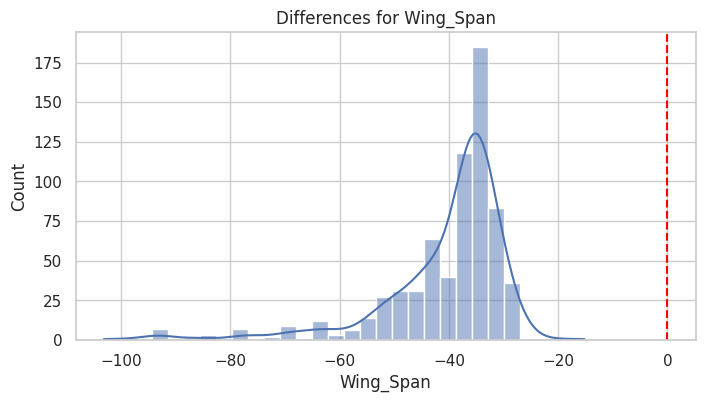

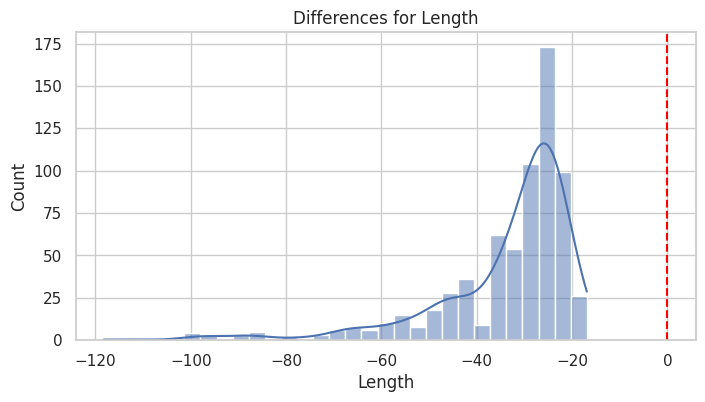

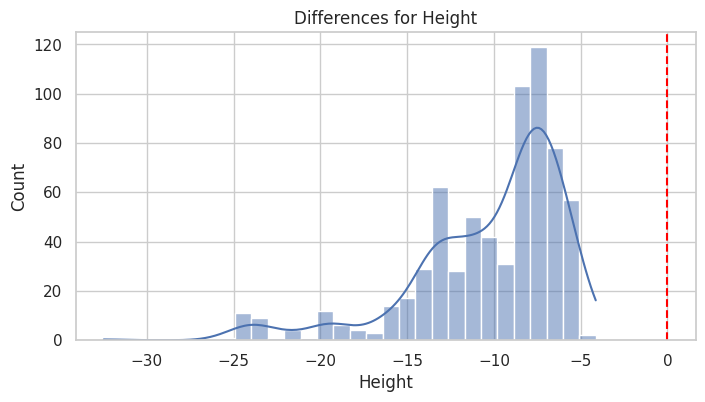

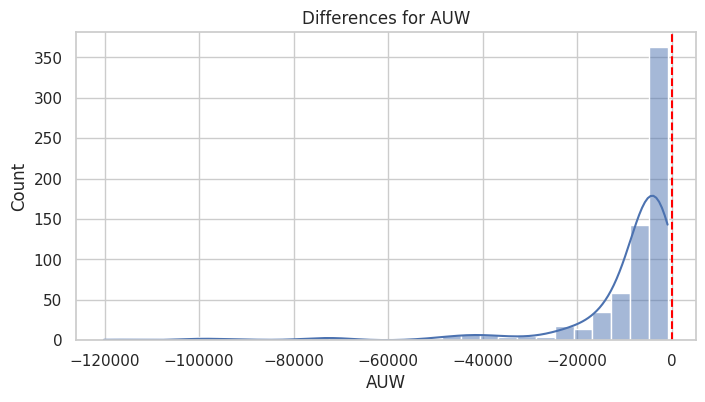

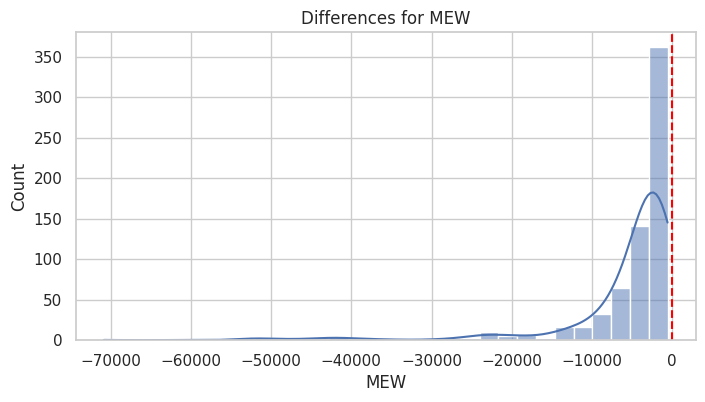

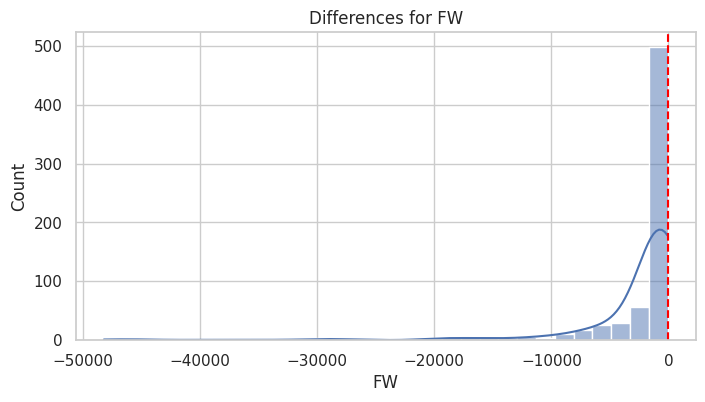

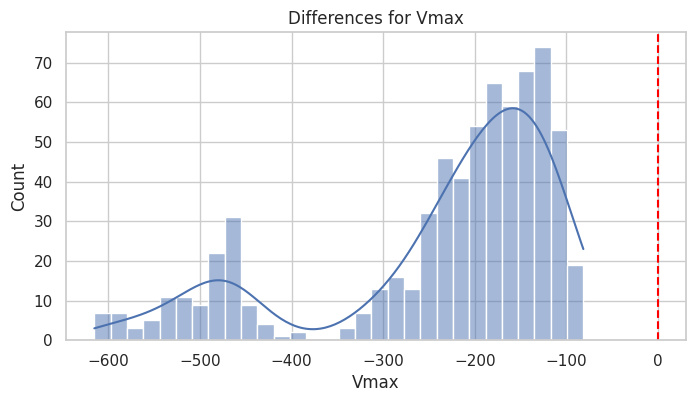

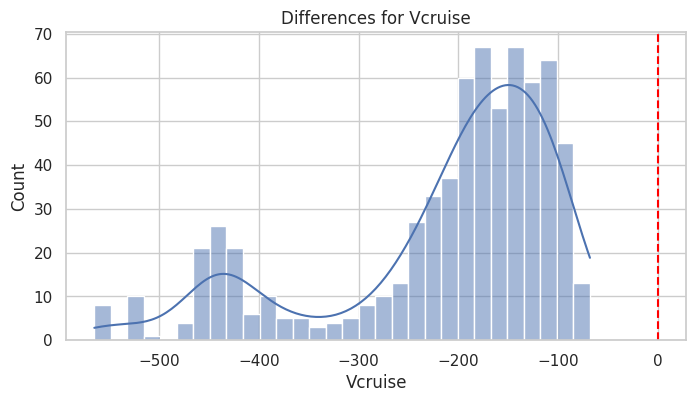

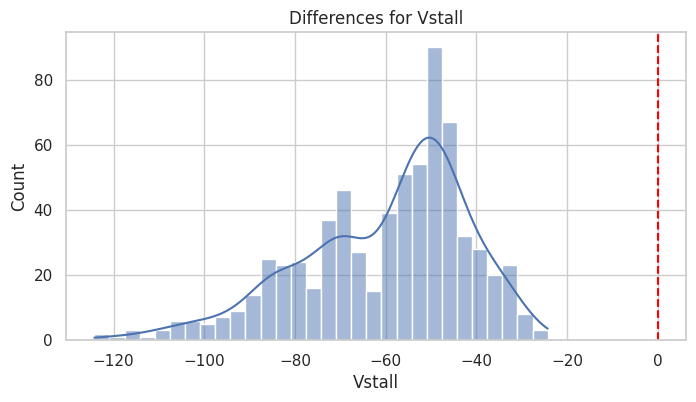

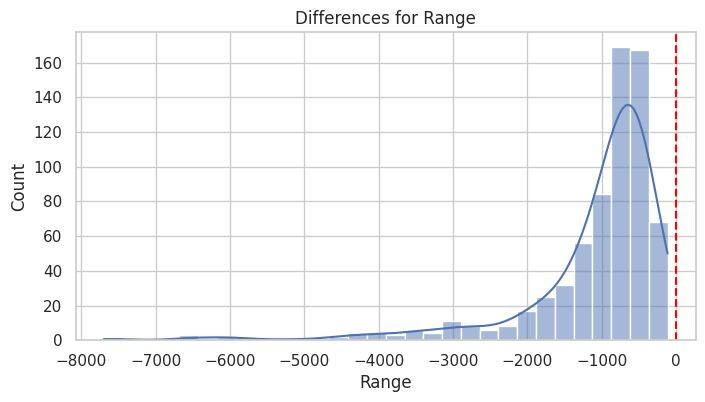

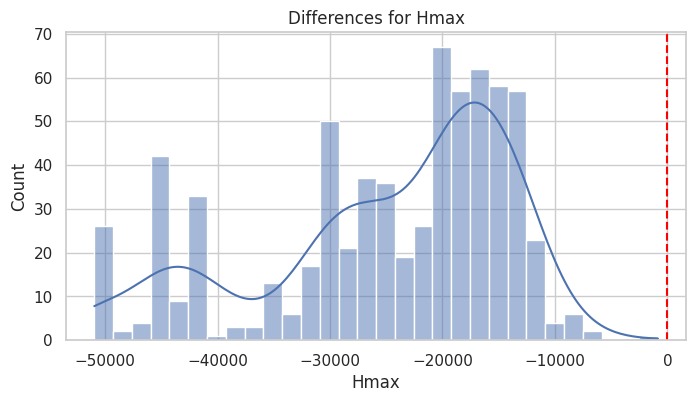

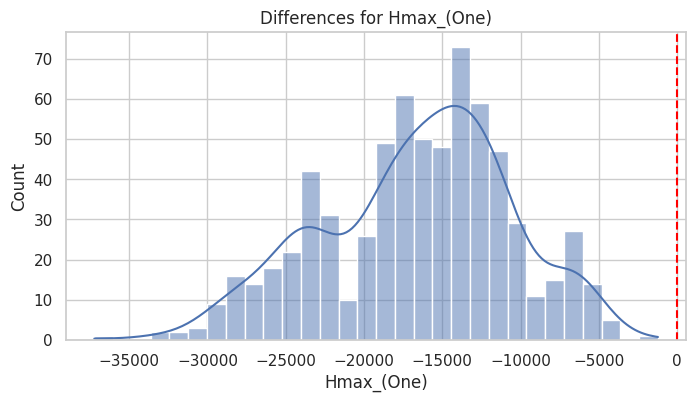

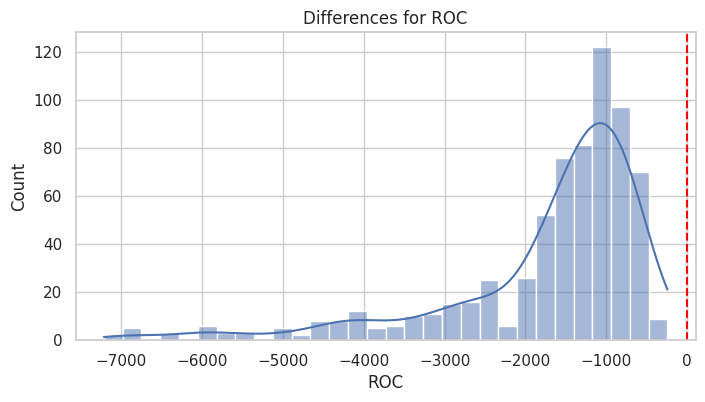

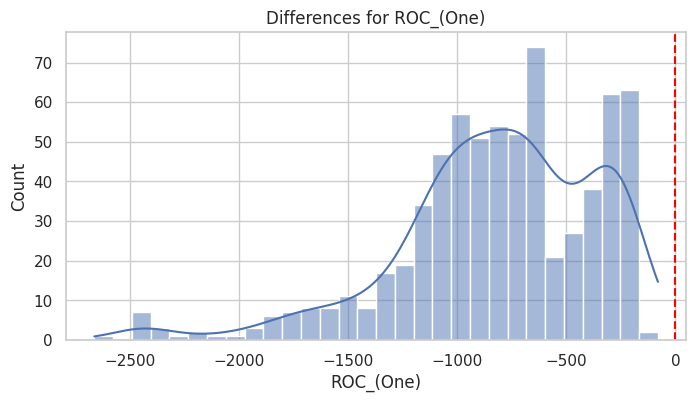

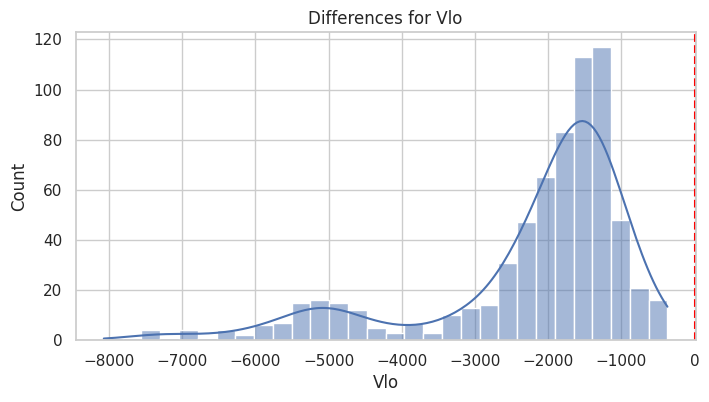

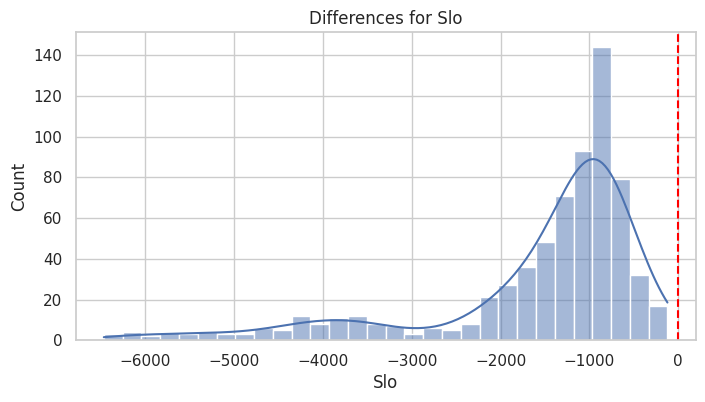

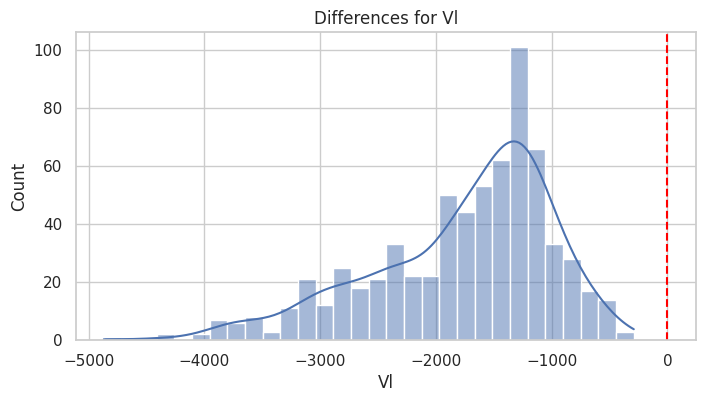

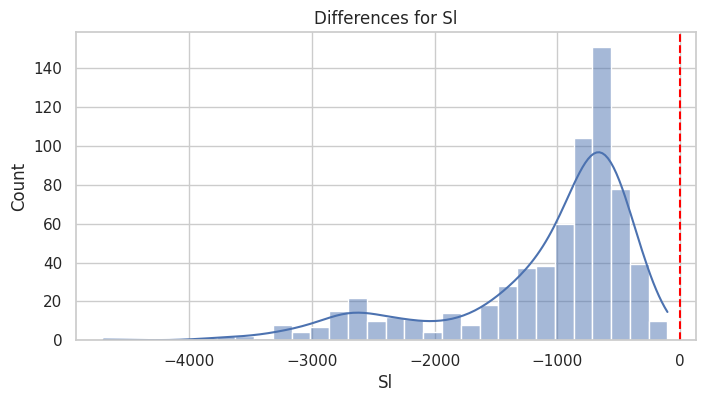

In [11]:
import pandas as pd
import numpy as np
from scipy import stats
from sklearn.preprocessing import PowerTransformer
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming df_engineering is your DataFrame
# df_engineering = pd.DataFrame(...)  # Load your DataFrame here

# List of columns to apply transformations
columns_to_transform = ['Wing_Span', 'Length', 'Height', 'AUW', 'MEW',
                        'FW', 'Vmax', 'Vcruise', 'Vstall', 'Range', 
                        'Hmax', 'Hmax_(One)', 'ROC', 'ROC_(One)',
                        'Vlo', 'Slo', 'Vl', 'Sl']

# Create a DataFrame to store transformed values
df_engineering_transformed = pd.DataFrame()

# Store the original DataFrame for difference calculation
original_df = df_engineering.copy()

# Apply transformations
for column in columns_to_transform:
    if column in df_engineering.columns:
        # Check for positive values for Box-Cox
        if (df_engineering[column] <= 0).any():
            # Use Yeo-Johnson for zero or negative values
            pt = PowerTransformer(method='yeo-johnson')
            transformed_values = pt.fit_transform(df_engineering[[column]])
            df_engineering_transformed[column] = transformed_values.flatten()  # Store transformed values
        else:
            # Use Box-Cox for positive values
            transformed_values, _ = stats.boxcox(df_engineering[column])
            df_engineering_transformed[column] = transformed_values  # Store transformed values

# Calculate differences
differences_df = df_engineering_transformed - original_df[columns_to_transform]

# Summary statistics of the differences
differences_stats = differences_df.describe()
print("Differences Statistics:\n", differences_stats)

# Plotting differences
for column in columns_to_transform:
    plt.figure(figsize=(8, 4))
    sns.histplot(differences_df[column], bins=30, kde=True)
    plt.title(f'Differences for {column}')
    plt.axvline(0, color='red', linestyle='--')  # Line at 0 for reference
    plt.show()


### SmartCorrelatedSelection Variables

* Step 1: Create a separate DataFrame, with your variable(s)

In [12]:
df_engineering = TrainSet.copy()
df_engineering.head(3)

,Wing_Span,Length,Height,Multi_Engine,TP_mods,Engine_Type,AUW,MEW,FW,Vmax,...,Vstall,Range,Hmax,Hmax_(One),ROC,ROC_(One),Vlo,Slo,Vl,Sl
0,64.333333,68.416667,20.666667,0,0,2,48300.0,26985.0,20000.0,546.94,...,99.659388,4045.0,41000.0,20000.0,2512.569226,680.0,6969.145819,5684.0,3693.285251,2777.0
1,37.166667,31.166667,10.250000,0,0,0,5200.0,3229.0,964.8,220.00,...,59.000000,620.0,30000.0,18700.0,1530.000000,265.0,1250.000000,820.0,1250.000000,850.0
2,37.666667,25.583333,9.500000,0,0,0,4880.0,2960.0,750.4,200.00,...,66.000000,745.0,19200.0,7600.0,1630.000000,350.0,1700.000000,1255.0,1470.000000,1250.0


* Step 2: Create engineered variables(s) applying the transformation(s)

In [13]:
from feature_engine.selection import SmartCorrelatedSelection
corr_sel = SmartCorrelatedSelection(variables=None, method="spearman", threshold=0.9, selection_method="variance")

corr_sel.fit_transform(df_engineering)
corr_sel.correlated_feature_sets_

[{'AUW', 'FW', 'Height', 'Length', 'MEW'},
 {'Hmax', 'ROC', 'Vcruise', 'Vmax', 'Vstall'},
 {'Slo', 'Vlo'}]

In [14]:
corr_sel.features_to_drop_

['Length', 'Height', 'MEW', 'FW', 'Vmax', 'Vcruise', 'Vstall', 'ROC', 'Slo']

corr_sel.features_to_drop_ gives ['Length', 'MEW', 'Vcruise'] to drop however we manually intervene here and apply our "Domain Specific Knowledge" to slightly alter this selection since we want to retain Vcruise.

In [16]:
# List of features to drop
features_to_drop = ['Length', 'MEW']

# Dropping the specified features
df_engineering_dropped = df_engineering.drop(columns=features_to_drop)

---

# Conclusion


The list below shows the transformations needed for feature engineering.


Feature Engineering Transformers
  * Ordinal categorical encoding: `['Multi Engine',	'TP mods',	'Engine Type']`
  * Smart Correlation Selection: `['Length', 'MEW']`
  